In [168]:
import polars as pl
import pandas as pd
import polars.selectors as cs 
import numpy as np
from scipy.stats import sem, t, rankdata
import seaborn as sns
from inspect import signature
from typing import Callable
import matplotlib.pyplot as plt 

In [254]:
def list_eval_ref(
    listcol: pl.Expr | str,
    op: Callable[..., pl.Expr],
    *ref_cols: str | pl.Expr,
):
    if len(ref_cols)==0:
        ref_cols = tuple([x for x in signature(op).parameters.keys()][1:])
    
    args_to_op = [pl.element().struct[0].explode()] + [
        pl.element().struct[i + 1] for i in range(len(ref_cols))
    ]
    return pl.concat_list(pl.struct(listcol, *ref_cols)).list.eval(op(*args_to_op))

def processing(df: pl.DataFrame):
    df = df.sort(pl.col('subjectID', 'trial'))

    match = cs.matches(r'^valArm(?:[1-9]|1[0-9]|20)$')
    noise_arm_match = cs.matches(r'^noiseArm(?:[1-9]|1[0-9]|20)$')
    # rand_arm_match = cs.matches(r'^randArm(?:[1-9]|1[0-9]|20)$')

    train_df = df.filter(pl.col('phase') == 'training')

    train_df = train_df.with_columns(
        all_arm_vals = pl.concat_list(match),
        all_noise_vals = pl.concat_list(noise_arm_match),
        # rand_arm_vals = pl.concat_list(rand_arm_match)
    )

    train_df = train_df.with_columns(
        true_arm_vals = pl.struct('all_arm_vals', 'all_noise_vals')
        .map_batches(
            lambda x: x.struct.field('all_arm_vals') - x.struct.field('all_noise_vals')        
        )
    )

    train_df = train_df.with_columns(
        true_arm_rankings = pl.col('true_arm_vals')
        .map_elements(
            lambda x: x.rank(descending=True, method='min'),
            return_dtype=pl.List(pl.Int8)
        )
    )
    
    # train_df = train_df.with_columns(
    #     true_selected_arm_val = pl.struct('chosenArm', 'rand_arm_vals')
    #     .map_batches(
    #         lambda x: x.struct.field('rand_arm_vals').list.get(x.struct.field('chosenArm') - 1),
    #     )
    # )

    train_df = train_df.with_columns(
        chosenRank = pl.struct('true_arm_rankings', 'chosenArm')
        .map_batches(
            lambda x: x.struct.field('true_arm_rankings').list.get(x.struct.field('chosenArm') - 1) 
        )
    )

    grouped_chosen_ranks = train_df.group_by('trial', 'expCond').agg(pl.col('chosenRank').mean())

    return train_df, grouped_chosen_ranks


In [131]:
df = pl.read_csv('/Users/jeremiahetiosaomeike/research_projects/lbd/data/exp1_banditData.csv', null_values='NA')
df = df.sort(pl.col('subjectID', 'trial'))

In [252]:
train_df, _ = processing(df)
train_df

browser,platform,subjectID,expID,expCond,totalTime,phase,trial,keyPress,chosenArm,choiceRT,rewardObtained,rewardMax,regret,correct,switch,runningTotal,valArm1,randArm1,valArm2,randArm2,valArm3,randArm3,valArm4,randArm4,valArm5,randArm5,valArm6,randArm6,valArm7,randArm7,valArm8,randArm8,valArm9,randArm9,valArm10,randArm10,…,noiseArm13,nameArm13,valArm14feat1,valArm14feat2,noiseArm14,nameArm14,valArm15feat1,valArm15feat2,noiseArm15,nameArm15,valArm16feat1,valArm16feat2,noiseArm16,nameArm16,valArm17feat1,valArm17feat2,noiseArm17,nameArm17,valArm18feat1,valArm18feat2,noiseArm18,nameArm18,valArm19feat1,valArm19feat2,noiseArm19,nameArm19,valArm20feat1,valArm20feat2,noiseArm20,nameArm20,weight1,weight2,all_arm_vals,all_noise_vals,true_arm_vals,true_arm_rankings,chosenRank
str,str,i64,str,str,f64,str,i64,i64,i64,i64,f64,f64,f64,i64,i64,f64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,…,f64,str,f64,f64,f64,str,f64,f64,f64,str,f64,f64,f64,str,f64,f64,f64,str,f64,f64,f64,str,f64,f64,f64,str,f64,f64,f64,str,i64,i64,list[f64],list[f64],list[f64],list[i8],i8
"""chrome""","""windows""",2,"""exp1highReward""","""CMAB_Lin_NoIns""",10.816433,"""training""",1,19,20,9712,2.721505,3.561307,0.839802,0,0,22.721505,1.327617,2,1.718571,9,1.876731,6,2.88524,10,2.065993,15,1.109209,8,3.464238,12,1.913467,11,1.214639,1,2.352129,4,…,1.099039,"""inter""",0.216667,0.821464,-0.494095,"""inter""",0.127428,0.167216,-1.310707,"""inter""",0.283032,0.525127,-0.138439,"""inter""",0.711361,0.112186,-0.495821,"""inter""",0.753527,0.607805,1.323672,"""inter""",0.677082,0.632203,0.998222,"""inter""",0.803621,0.732499,0.452885,"""inter""",1,2,"[1.327617, 1.718571, … 2.721505]","[0.203984, 0.557114, … 0.452885]","[1.123634, 1.161457, … 2.268619]","[16, 15, … 3]",3
"""chrome""","""windows""",2,"""exp1highReward""","""CMAB_Lin_NoIns""",10.816433,"""training""",2,18,19,5833,1.082311,3.991859,2.909548,0,1,23.803816,1.207088,2,2.114623,9,2.573887,6,2.285075,10,1.24303,15,1.525026,8,1.987652,12,-0.849392,11,2.314265,1,3.315799,4,…,-0.09522,"""inter""",0.216667,0.821464,-1.032388,"""inter""",0.127428,0.167216,0.999521,"""inter""",0.283032,0.525127,2.658572,"""inter""",0.711361,0.112186,0.230814,"""inter""",0.753527,0.607805,0.142077,"""inter""",0.677082,0.632203,-0.859178,"""inter""",0.803621,0.732499,-0.466765,"""inter""",1,2,"[1.207088, 2.114623, … 1.801855]","[0.083454, 0.953166, … -0.466765]","[1.123634, 1.161457, … 2.268619]","[16, 15, … 3]",9
"""chrome""","""windows""",2,"""exp1highReward""","""CMAB_Lin_NoIns""",10.816433,"""training""",3,0,1,2766,0.619955,3.496261,2.876306,0,1,24.423771,0.619955,2,-1.048898,9,1.276719,6,2.189622,10,3.052373,15,1.861023,8,1.53738,12,2.245228,11,1.266903,1,2.433701,4,…,1.033992,"""inter""",0.216667,0.821464,-1.014614,"""inter""",0.127428,0.167216,-0.023868,"""inter""",0.283032,0.525127,0.898417,"""inter""",0.711361,0.112186,0.085191,"""inter""",0.753527,0.607805,0.779204,"""inter""",0.677082,0.632203,-0.147048,"""inter""",0.803621,0.732499,-0.956391,"""inter""",1,2,"[0.619955, -1.048898, … 1.312229]","[-0.503679, -2.210355, … -0.956391]","[1.123634, 1.161457, … 2.268619]","[16, 15, … 3]",16
"""chrome""","""windows""",2,"""exp1highReward""","""CMAB_Lin_NoIns""",10.816433,"""training""",4,17,18,1000,3.218271,3.437353,0.219082,0,1,27.642042,1.744009,2,2.22625,9,0.881657,6,1.730071,10,0.50605,15,3.275484,8,0.37383,12,2.974462,11,1.766405,1,1.816545,4,…,-0.454141,"""inter""",0.216667,0.821464,1.577759,"""inter""",0.127428,0.167216,-1.915397,"""inter""",0.283032,0.525127,0.372876,"""inter""",0.711361,0.112186,1.924093,"""inter""",0.753527,0.607805,1.249134,"""inter""",0.677082,0.632203,-0.119374,"""inter""",0.803621,0.732499,-0.911789,"""inter""",1,2,"[1.744009, 2.22625, … 1.35683]","[0.620375, 1.064792, … -0.911789]","[1.123634, 1.161457, … 2.268619]","[16, 15, … 3]",8
"""chrome""","""windows""",2,"""exp1highReward""","""CMAB_Lin_NoIns""",10.816433,"""training""",5,16,17,1058,0.861198,4.974281,4.113083,0,1,28

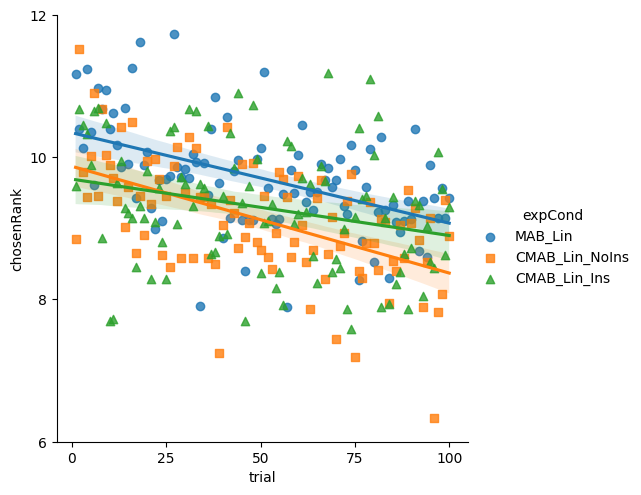

In [255]:
train_df, grouped_chosen_ranks = processing(df)

grouped_chosen_ranks_pd = grouped_chosen_ranks.to_pandas()
g = sns.lmplot(data=grouped_chosen_ranks, x='trial', y='chosenRank', hue='expCond', markers=['o', 's', '^'])
xticks = [0, 25, 50, 75, 100]
yticks = [6, 8, 10, 12]
g.set(xticks=xticks)
g.set(yticks=yticks)

In [106]:
train_df.group_by('trial', 'expCond')

browser,platform,subjectID,expID,expCond,totalTime,phase,trial,keyPress,chosenArm,choiceRT,rewardObtained,rewardMax,regret,correct,switch,runningTotal,valArm1,randArm1,valArm2,randArm2,valArm3,randArm3,valArm4,randArm4,valArm5,randArm5,valArm6,randArm6,valArm7,randArm7,valArm8,randArm8,valArm9,randArm9,valArm10,randArm10,…,valArm13feat1,valArm13feat2,noiseArm13,nameArm13,valArm14feat1,valArm14feat2,noiseArm14,nameArm14,valArm15feat1,valArm15feat2,noiseArm15,nameArm15,valArm16feat1,valArm16feat2,noiseArm16,nameArm16,valArm17feat1,valArm17feat2,noiseArm17,nameArm17,valArm18feat1,valArm18feat2,noiseArm18,nameArm18,valArm19feat1,valArm19feat2,noiseArm19,nameArm19,valArm20feat1,valArm20feat2,noiseArm20,nameArm20,weight1,weight2,all_arm_vals,all_arm_vals_shifted,chosenRank
str,str,i64,str,str,f64,str,i64,i64,i64,i64,f64,f64,f64,i64,i64,f64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,…,f64,f64,f64,str,f64,f64,f64,str,f64,f64,f64,str,f64,f64,f64,str,f64,f64,f64,str,f64,f64,f64,str,f64,f64,f64,str,f64,f64,f64,str,i64,i64,list[f64],list[f64],u32
"""chrome""","""windows""",2,"""exp1highReward""","""CMAB_Lin_NoIns""",10.816433,"""training""",1,19,20,9712,2.721505,3.561307,0.839802,0,0,22.721505,1.327617,2,1.718571,9,1.876731,6,2.88524,10,2.065993,15,1.109209,8,3.464238,12,1.913467,11,1.214639,1,2.352129,4,…,0.72645,0.867909,1.099039,"""inter""",0.216667,0.821464,-0.494095,"""inter""",0.127428,0.167216,-1.310707,"""inter""",0.283032,0.525127,-0.138439,"""inter""",0.711361,0.112186,-0.495821,"""inter""",0.753527,0.607805,1.323672,"""inter""",0.677082,0.632203,0.998222,"""inter""",0.803621,0.732499,0.452885,"""inter""",1,2,"[1.327617, 1.718571, … 2.721505]","[0.839802, 0.742733, … -3.570352]",5
"""chrome""","""windows""",2,"""exp1highReward""","""CMAB_Lin_NoIns""",10.816433,"""training""",2,18,19,5833,1.082311,3.991859,2.909548,0,1,23.803816,1.207088,2,2.114623,9,2.573887,6,2.285075,10,1.24303,15,1.525026,8,1.987652,12,-0.849392,11,2.314265,1,3.315799,4,…,0.72645,0.867909,-0.09522,"""inter""",0.216667,0.821464,-1.032388,"""inter""",0.127428,0.167216,0.999521,"""inter""",0.283032,0.525127,2.658572,"""inter""",0.711361,0.112186,0.230814,"""inter""",0.753527,0.607805,0.142077,"""inter""",0.677082,0.632203,-0.859178,"""inter""",0.803621,0.732499,-0.466765,"""inter""",1,2,"[1.207088, 2.114623, … 1.801855]","[2.909548, 2.233488, … -1.931703]",16
"""chrome""","""windows""",2,"""exp1highReward""","""CMAB_Lin_NoIns""",10.816433,"""training""",3,0,1,2766,0.619955,3.496261,2.876306,0,1,24.423771,0.619955,2,-1.048898,9,1.276719,6,2.189622,10,3.052373,15,1.861023,8,1.53738,12,2.245228,11,1.266903,1,2.433701,4,…,0.72645,0.867909,1.033992,"""inter""",0.216667,0.821464,-1.014614,"""inter""",0.127428,0.167216,-0.023868,"""inter""",0.283032,0.525127,0.898417,"""inter""",0.711361,0.112186,0.085191,"""inter""",0.753527,0.607805,0.779204,"""inter""",0.677082,0.632203,-0.147048,"""inter""",0.803621,0.732499,-0.956391,"""inter""",1,2,"[0.619955, -1.048898, … 1.312229]","[2.876306, 2.432417, … -1.668853]",17
"""chrome""","""windows""",2,"""exp1highReward""","""CMAB_Lin_NoIns""",10.816433,"""training""",4,17,18,1000,3.218271,3.437353,0.219082,0,1,27.642042,1.744009,2,2.22625,9,0.881657,6,1.730071,10,0.50605,15,3.275484,8,0.37383,12,2.974462,11,1.766405,1,1.816545,4,…,0.72645,0.867909,-0.454141,"""inter""",0.216667,0.821464,1.577759,"""inter""",0.127428,0.167216,-1.915397,"""inter""",0.283032,0.525127,0.372876,"""inter""",0.711361,0.112186,1.924093,"""inter""",0.753527,0.607805,1.249134,"""inter""",0.677082,0.632203,-0.119374,"""inter""",0.803621,0.732499,-0.911789,"""inter""",1,2,"[1.744009, 2.22625, … 1.35683]","[0.219082, 0.057213, … -4.671809]",2
"""chrome""","""windows""",2,"""exp1highReward""","""CMAB_Lin_NoIns""",10.816433,"""training""",5,16,17,1058,0.861198,4.974281,4.113083,0,1,28.50324,4.974281,2,2.21165,9,0.388026,6,1.220695,10,1.035577,15,0.634234,8,2.679628,12,1.841328,11,2.083442,1,4.21385,4,…,0.72645,0.867909,-0.116